In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.naive_bayes import CategoricalNB

In [89]:
file_path = "/mnt/c/CP322/Pokemon.csv"
data_frame = pd.read_csv(file_path)
# Display first 10 rows
data_frame.head(10)

,number,name,type1,type2,total,hp,attack,defense,sp_attack,sp_defense,speed,generation,legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,Mega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,3,Gigantamax Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
5,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
6,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False
7,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False
8,6,Mega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,False
9,6,Mega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,False


In [90]:
# Describe dataset
data_frame.describe()

,number,total,hp,attack,defense,sp_attack,sp_defense,speed,generation
count,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000
mean,445.219216,440.885261,70.486940,80.938433,74.968284,73.273321,72.476679,68.792910,4.294776
std,267.772806,121.379077,26.868039,32.463582,31.208059,32.643119,27.934253,30.076281,2.346472
min,1.000000,175.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,0.000000
25%,209.750000,330.000000,50.000000,56.000000,52.000000,50.000000,50.000000,45.000000,2.000000
50%,442.500000,460.500000,68.000000,80.000000,70.000000,65.000000,70.000000,65.000000,4.000000
75%,681.250000,519.250000,84.000000,100.000000,90.000000,95.000000,90.000000,90.000000,6.000000
max,898.000000,1125.000000,255.000000,190.000000,250.000000,194.000000,250.000000,200.000000,8.000000


In [91]:
# Check for missing values in every column
missing_values = data_frame.isnull().sum()
missing_columns = missing_values[missing_values > 0]
print("Columns with missing values:\n", missing_columns)

Columns with missing values:
 type2    498
dtype: int64


In [92]:
# Drop columns with 1+ null values
data_frame = data_frame.dropna(axis=1)
print("Removed the following features from dataset:\n", missing_columns)

Removed the following features from dataset:
 type2    498
dtype: int64


In [93]:
# Drops name and number, they do not provide useful information for prediction
# Additionally, using one-hot encoding on name results in a unique column for each pokemon (1000+ columns)
data_frame = data_frame.drop(columns=['number', 'name'])
# Uses one-hot encoding to create new columns for each unique catergory in categorical features
X = pd.get_dummies(data_frame)
# Set y to target value column
y = X['legendary']
# Remove target feature from x set
X = X.drop(columns=['legendary'])
# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [94]:
# Train logistic regression model with 1000 iterations
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
# Predicts test values and classifies with threshold of 0.5
logistic_pred_values = model.predict_proba(X_test)[:, 1]
y_pred = (logistic_pred_values >= 0.5)

# Calculate precision, recall, f1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Precision: 0.778
Recall: 0.560
F1 Score: 0.651


/home/matteopassalent/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [95]:
# Set k range from 1 to 10
k_values = range(1, 11)
cv_scores = []

# Performs 10-fold cross-validation for each k (1-10)
for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    scores = cross_val_score(knn_model, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find optimal k value, with corresponding optimal score
optimal_k = k_values[np.argmax(cv_scores)]
optimal_score = max(cv_scores)

optimal_model = KNeighborsClassifier(n_neighbors=optimal_k, metric='manhattan')
optimal_model.fit(X_train, y_train)
knn_pred_values = optimal_model.predict_proba(X_test)[:, 1]

print(f"Optimal K value: {optimal_k}")
print(f"Cross-validation accuracy for optimal K: {optimal_score:.3f}")

Optimal K value: 1
Cross-validation accuracy for optimal K: 0.952


In [96]:
# Initialize discretizer, forms bin edges and applies bins to training and testing data
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
X_train_binned = discretizer.fit_transform(X_train)
X_test_binned = discretizer.transform(X_test)

# Train Categorical Naive Bayes model on binned data
model = CategoricalNB()
model.fit(X_train_binned, y_train)
nb_pred_values = model.predict_proba(X_test_binned)[:, 1]
y_pred = (nb_pred_values >= 0.5)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print evaluation metrics
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Precision: 0.657
Recall: 0.920
F1 Score: 0.767


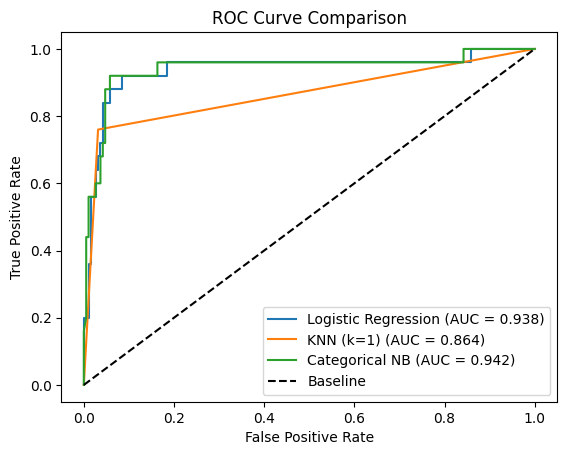

The best model is Categorical NB with an AUC of 0.942.


In [97]:
# Calculate ROC curve and AUC for logistic model
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, logistic_pred_values)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

# Calculate ROC curve and AUC for KNN model
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_pred_values)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Calculate ROC curve and AUC for Categorical NB model
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_pred_values)
roc_auc_nb = auc(fpr_nb, tpr_nb)

# Plot the ROC curves from each model with AUC label
plt.plot(fpr_logistic, tpr_logistic, label=f'Logistic Regression (AUC = {roc_auc_logistic:.3f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (k={optimal_k}) (AUC = {roc_auc_knn:.3f})')
plt.plot(fpr_nb, tpr_nb, label=f'Categorical NB (AUC = {roc_auc_nb:.3f})')

# Add baseline for random prediction
plt.plot([0, 1], [0, 1], 'k--', label="Baseline")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

best_model = max((roc_auc_logistic, "Logistic Regression"), (roc_auc_knn, "KNN"), (roc_auc_nb, "Categorical NB"), key=lambda x: x[0])
print(f"The best model is {best_model[1]} with an AUC of {best_model[0]:.3f}.")

In [100]:
# Extract only continous features
continous_features = ['hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed']
X_data = data_frame[continous_features]
# Set y to target value column
y_data = data_frame['total']
# Create train/test split
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Initialize and train Linear model
model = LinearRegression()
model.fit(X_train_data, y_train_data)
y_pred = model.predict(X_test_data)

# Calculate MSE
mse = mean_squared_error(y_test_data, y_pred)
print(f"Mean Squared Error: {mse:.3f}")

Mean Squared Error: 0.009


In [113]:
# Initialize Lasso and Ridge models
lasso_model = Lasso(max_iter=1000)
ridge_model = Ridge(max_iter=1000)

# Train Lasso model
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

# Train Ridge model
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

# Calculate MSE for both models
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print(f"Lasso Regression MSE: {mse_lasso:.3f}")
print(f"Ridge Regression MSE: {mse_ridge:.3f}")

Lasso Regression MSE: 0.080
Ridge Regression MSE: 0.079
